In [1]:
import numpy as np 
import pandas as pd 
import random

In [2]:
import seaborn as sns 
import matplotlib.pyplot as plt 

plt.style.use('ggplot')
%matplotlib inline

In [3]:
df_feature = pd.read_csv('../input/raw/tox21_dense_train.csv')
df_target = pd.read_csv('../input/raw/tox21_labels_train.csv')

In [4]:
df_feature_test = pd.read_csv('../input/raw/tox21_dense_test.csv')
df_target_test = pd.read_csv('../input/raw/tox21_labels_test.csv')

### Helper Functions

In [5]:
# def target_transform(df):
#     df = df.fillna(2)    
#     target_cols = df.columns.tolist()[1:]

#     df_ohe = None
#     for col in target_cols:
#         temp = pd.get_dummies(df[col],prefix='target_'+col)
#         df_ohe = pd.concat([df,temp],axis=1)
    
#     df_ohe = df_ohe.rename(columns={"Unnamed: 0": "id"})
    
#     return df_ohe

### Target analysis

In [6]:
df_target.head()

,Unnamed: 0,NR.AhR,NR.AR,NR.AR.LBD,NR.Aromatase,NR.ER,NR.ER.LBD,NR.PPAR.gamma,SR.ARE,SR.ATAD5,SR.HSE,SR.MMP,SR.p53
0,NCGC00178831-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
1,NCGC00166114-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
2,NCGC00263563-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
3,NCGC00013058-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
4,NCGC00167516-01,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df_target.shape

(12060, 13)

In [8]:
df_target.iloc[3,1:].isna().sum() == 12

False

### Checking NaN individually

In [9]:
#  ovarall nan
df_target.dropna().shape

(2668, 13)

In [10]:
#individual nan
each_target_non_nan = []
each_target_zeros = []
each_target_ones = []

for col in df_target.columns[1:]:
    each_target_non_nan.append(df_target[col].dropna().shape[0])
    each_target_zeros.append(df_target[col].dropna().value_counts()[0])
    each_target_ones.append(df_target[col].dropna().value_counts()[1])

In [11]:
print("All: \t",each_target_non_nan)
print("Zeros: \t",each_target_zeros)
print("Ones: \t",each_target_ones)
print("Ones: \t",np.round(np.array(each_target_ones)/np.array(each_target_non_nan)*100))

All: 	 [8441, 9654, 8852, 7440, 7962, 9040, 8451, 7401, 9363, 8417, 7558, 8903]
Zeros: 	 [7460, 9271, 8545, 7062, 6998, 8584, 8214, 6255, 9000, 7979, 6378, 8338]
Ones: 	 [981, 383, 307, 378, 964, 456, 237, 1146, 363, 438, 1180, 565]
Ones: 	 [12.  4.  3.  5. 12.  5.  3. 15.  4.  5. 16.  6.]


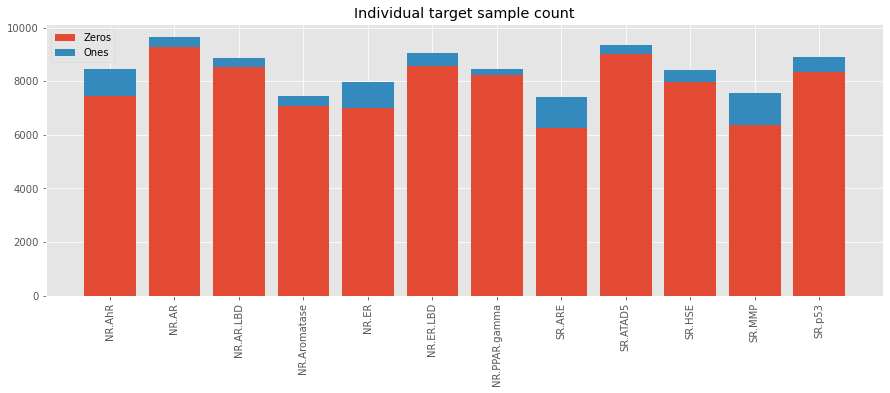

In [12]:
plt.figure(figsize=(15,5))
plt.bar(x=df_target.columns[1:].tolist(),height=np.array(each_target_zeros))
plt.bar(x=df_target.columns[1:].tolist(),height=np.array(each_target_ones),bottom=np.array(each_target_zeros))
plt.title("Individual target sample count")
plt.xticks(rotation='vertical')
plt.legend(["Zeros", "Ones"])
plt.show()

### Checking if there exist any row with all NaN value

In [13]:
# count = 0
# mol_idx = []
# for i in range(df_target.shape[0]):
#     temp = df_target.iloc[i,:]
#     if df_target.iloc[i,1:].isna().sum() == 12:
#         count += 1
#         mol_idx.append(i)

In [14]:
# count

No there is no such row with all NaN values.

### Checking if there exist any row with all zero values if we replace NaN with zero

In [15]:
df_target.fillna(0).head()

,Unnamed: 0,NR.AhR,NR.AR,NR.AR.LBD,NR.Aromatase,NR.ER,NR.ER.LBD,NR.PPAR.gamma,SR.ARE,SR.ATAD5,SR.HSE,SR.MMP,SR.p53
0,NCGC00178831-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,NCGC00166114-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NCGC00263563-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NCGC00013058-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,NCGC00167516-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
# count = 0
# mol_idx = []
# for i in range(df_target.shape[0]):
#     temp = df_target.iloc[i,:]
#     if df_target.iloc[i,1:].sum() == 0:
#         count += 1
#         mol_idx.append(i)

In [17]:
# count

We cannot assign 0 value as it will corrupt the original zero values, so lets assign 2 for all NaN values. This will make it a multiclass-multilabel (multi-task) problem type.  
- We can do the one-hot-encode of the target
- Or can use some other MultiTqaskLearning methods

### Training target transformation

The labels semantic meaning:  
- 0 : non-toxic
- 1 : toxic
- 2 : don't care

In [18]:
def target_transform(df):
    df = df.fillna(2)    
    target_cols = df.columns.tolist()[1:]
    
    ohe_dict = {}
    col_order = []
    for col in target_cols:
        ohe_dict[col + "_zero"] = (df[col].values == 0).astype(np.int).tolist()
        ohe_dict[col + "_one"] = (df[col].values == 1).astype(np.int).tolist()
        ohe_dict[col + "_two"] = (df[col].values == 2).astype(np.int).tolist()
        col_order = col_order + [col + "_zero", col + "_one", col + "_two"]
    df_ohe = pd.DataFrame(ohe_dict)
    df_ohe['id'] = df["Unnamed: 0"] # get ids
    df_ohe = df_ohe[['id'] + col_order] # desired column order
        
    return df_ohe

In [19]:
df_target.head()

,Unnamed: 0,NR.AhR,NR.AR,NR.AR.LBD,NR.Aromatase,NR.ER,NR.ER.LBD,NR.PPAR.gamma,SR.ARE,SR.ATAD5,SR.HSE,SR.MMP,SR.p53
0,NCGC00178831-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
1,NCGC00166114-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
2,NCGC00263563-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
3,NCGC00013058-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
4,NCGC00167516-01,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
df_target.shape

(12060, 13)

In [21]:
df_target_ohe = target_transform(df = df_target)

In [22]:
df_target_ohe.shape

(12060, 37)

In [23]:
df_target_ohe.head()

,id,NR.AhR_zero,NR.AhR_one,NR.AhR_two,NR.AR_zero,NR.AR_one,NR.AR_two,NR.AR.LBD_zero,NR.AR.LBD_one,NR.AR.LBD_two,...,SR.ATAD5_two,SR.HSE_zero,SR.HSE_one,SR.HSE_two,SR.MMP_zero,SR.MMP_one,SR.MMP_two,SR.p53_zero,SR.p53_one,SR.p53_two
0,NCGC00178831-03,0,0,1,0,0,1,0,0,1,...,1,1,0,0,0,0,1,0,0,1
1,NCGC00166114-03,0,0,1,0,0,1,0,0,1,...,1,1,0,0,0,0,1,0,0,1
2,NCGC00263563-01,0,0,1,0,0,1,0,0,1,...,1,1,0,0,0,0,1,0,0,1
3,NCGC00013058-02,0,0,1,0,0,1,0,0,1,...,1,0,1,0,0,0,1,0,0,1
4,NCGC00167516-01,0,0,1,1,0,0,0,0,1,...,1,0,0,1,0,0,1,0,0,1


In [24]:
df_target_ohe.to_csv('../input/processed/train_targets_ohe.csv',index=False)

### Test target transform

In [25]:
df_target_test.head()

,Unnamed: 0,NR.AhR,NR.AR,NR.AR.LBD,NR.Aromatase,NR.ER,NR.ER.LBD,NR.PPAR.gamma,SR.ARE,SR.ATAD5,SR.HSE,SR.MMP,SR.p53
0,NCGC00261900-01,0.0,1.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0
1,NCGC00260869-01,0.0,1.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NCGC00261776-01,1.0,1.0,0.0,NaN,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
3,NCGC00261380-01,NaN,0.0,NaN,1.0,0.0,NaN,NaN,1.0,0.0,NaN,0.0,NaN
4,NCGC00261842-01,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0


In [26]:
df_target_test.shape

(647, 13)

In [27]:
df_test_target_ohe = target_transform(df = df_target_test)

In [28]:
df_test_target_ohe.shape

(647, 37)

In [29]:
df_test_target_ohe.head()

,id,NR.AhR_zero,NR.AhR_one,NR.AhR_two,NR.AR_zero,NR.AR_one,NR.AR_two,NR.AR.LBD_zero,NR.AR.LBD_one,NR.AR.LBD_two,...,SR.ATAD5_two,SR.HSE_zero,SR.HSE_one,SR.HSE_two,SR.MMP_zero,SR.MMP_one,SR.MMP_two,SR.p53_zero,SR.p53_one,SR.p53_two
0,NCGC00261900-01,1,0,0,0,1,0,0,0,1,...,0,1,0,0,0,0,1,1,0,0
1,NCGC00260869-01,1,0,0,0,1,0,0,0,1,...,0,1,0,0,1,0,0,1,0,0
2,NCGC00261776-01,0,1,0,0,1,0,1,0,0,...,0,1,0,0,0,1,0,1,0,0
3,NCGC00261380-01,0,0,1,1,0,0,0,0,1,...,0,0,0,1,1,0,0,0,0,1
4,NCGC00261842-01,1,0,0,1,0,0,1,0,0,...,0,1,0,0,0,0,1,0,1,0


In [30]:
df_test_target_ohe.to_csv('../input/processed/test_targets_ohe.csv',index=False)

In [31]:
df_test_target_ohe.shape

(647, 37)

In [32]:
df_target_ohe.shape

(12060, 37)

### plotting target columns ones-count

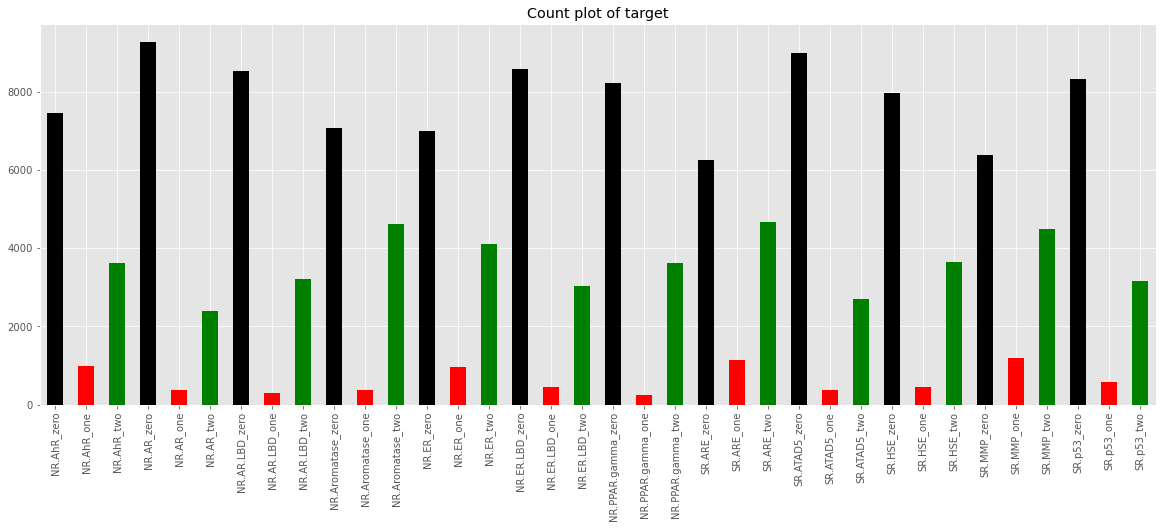

In [33]:
plt.figure(figsize=(20,7))
df_target_ohe.iloc[:,1:].sum().plot(kind='bar',color=['black', 'red', 'green'])
plt.title('Count plot of target')
plt.show()

### Feature analysis

In [34]:
df_feature.head()

,Unnamed: 0,AW,AWeight,Arto,BertzCT,Chi0,Chi1,Chi10,Chi2,Chi3,...,W3D,W3DH,WNSA1,WNSA2,WNSA3,WPSA1,WPSA2,WPSA3,grav,rygr
0,NCGC00178831-03,5.436720e+07,13.053,2.176,3.194,23.112,15.868,1.496,15.127,12.592,...,2687.469,9241.018,115.371,-915.496,-39.983,290.078,2301.941,59.492,88.147,3.708
1,NCGC00166114-03,1.268818e+07,22.123,2.065,3.137,21.033,13.718,1.937,13.187,11.951,...,2184.384,3234.199,194.740,-1029.609,-34.205,235.360,1244.323,82.906,134.852,4.131
2,NCGC00263563-01,3.076932e+06,13.085,2.154,3.207,46.896,29.958,3.806,30.105,25.569,...,13803.524,76582.899,238.004,-4358.946,-106.537,868.685,15909.444,135.335,216.852,5.075
3,NCGC00013058-02,7.168569e+07,12.832,2.029,3.380,51.086,32.045,1.806,29.090,21.603,...,13807.345,50498.175,226.312,-2785.555,-61.923,763.288,9394.859,125.509,238.265,4.640
4,NCGC00167516-01,7.989702e+06,12.936,2.124,3.573,70.295,46.402,3.604,42.132,32.570,...,43231.286,163659.229,850.869,-21136.699,-367.122,1798.703,44681.209,362.168,317.901,7.845


### Checking NaN values in the data

In [35]:
df_feature.isna().sum().sum()

0

No there exist no NaN values in the feature columns

### Checking for categorical and numerical columns

In [36]:
df_feature.columns.shape

(802,)

In [37]:
df_feature.dtypes.value_counts()

float64    761
int64       40
object       1
dtype: int64

In [38]:
df_feature.select_dtypes(include=np.float64).head()

,AW,AWeight,Arto,BertzCT,Chi0,Chi1,Chi10,Chi2,Chi3,Chi3c,...,W3D,W3DH,WNSA1,WNSA2,WNSA3,WPSA1,WPSA2,WPSA3,grav,rygr
0,5.436720e+07,13.053,2.176,3.194,23.112,15.868,1.496,15.127,12.592,2.619,...,2687.469,9241.018,115.371,-915.496,-39.983,290.078,2301.941,59.492,88.147,3.708
1,1.268818e+07,22.123,2.065,3.137,21.033,13.718,1.937,13.187,11.951,2.502,...,2184.384,3234.199,194.740,-1029.609,-34.205,235.360,1244.323,82.906,134.852,4.131
2,3.076932e+06,13.085,2.154,3.207,46.896,29.958,3.806,30.105,25.569,7.819,...,13803.524,76582.899,238.004,-4358.946,-106.537,868.685,15909.444,135.335,216.852,5.075
3,7.168569e+07,12.832,2.029,3.380,51.086,32.045,1.806,29.090,21.603,5.222,...,13807.345,50498.175,226.312,-2785.555,-61.923,763.288,9394.859,125.509,238.265,4.640
4,7.989702e+06,12.936,2.124,3.573,70.295,46.402,3.604,42.132,32.570,7.002,...,43231.286,163659.229,850.869,-21136.699,-367.122,1798.703,44681.209,362.168,317.901,7.845


In [39]:
float_cols = df_feature.select_dtypes(include=np.float64).columns.tolist()

In [40]:
df_feature.select_dtypes(include=np.int64).head()

,MRVSA7,PC1,PC2,PC3,PC4,PC5,PC6,Platt,Pol,Qindex,...,noxy,nphos,nring,nrot,nsb,nsulph,nta,ntb,slogPVSA8,RNCS
0,0,37,54,72,98,136,146,108,54,26,...,0,0,6,0,5,0,59,0,0,0
1,0,32,49,71,98,140,181,98,59,22,...,5,0,4,2,9,5,37,0,0,0
2,0,70,111,153,210,276,338,222,126,54,...,17,0,7,13,69,17,148,0,0,0
3,0,69,92,108,120,152,170,184,90,28,...,12,0,6,6,31,12,122,0,0,0
4,0,103,141,176,223,265,292,282,142,53,...,14,0,8,32,60,14,184,0,0,0


In [41]:
int_cols = df_feature.select_dtypes(include=np.int64).columns.tolist()

In [42]:
# for col in int_cols:
#     fig, ax = plt.subplots(figsize=(20,5))
#     sns_plot = sns.countplot(x = df_feature[col],ax=ax)
#     sns_plot.figure.savefig(f"../images/int_{col}.png")
#     plt.show()

### Floating columns analysis

In [43]:
df_float = df_feature[float_cols]

In [44]:
df_float.head()

,AW,AWeight,Arto,BertzCT,Chi0,Chi1,Chi10,Chi2,Chi3,Chi3c,...,W3D,W3DH,WNSA1,WNSA2,WNSA3,WPSA1,WPSA2,WPSA3,grav,rygr
0,5.436720e+07,13.053,2.176,3.194,23.112,15.868,1.496,15.127,12.592,2.619,...,2687.469,9241.018,115.371,-915.496,-39.983,290.078,2301.941,59.492,88.147,3.708
1,1.268818e+07,22.123,2.065,3.137,21.033,13.718,1.937,13.187,11.951,2.502,...,2184.384,3234.199,194.740,-1029.609,-34.205,235.360,1244.323,82.906,134.852,4.131
2,3.076932e+06,13.085,2.154,3.207,46.896,29.958,3.806,30.105,25.569,7.819,...,13803.524,76582.899,238.004,-4358.946,-106.537,868.685,15909.444,135.335,216.852,5.075
3,7.168569e+07,12.832,2.029,3.380,51.086,32.045,1.806,29.090,21.603,5.222,...,13807.345,50498.175,226.312,-2785.555,-61.923,763.288,9394.859,125.509,238.265,4.640
4,7.989702e+06,12.936,2.124,3.573,70.295,46.402,3.604,42.132,32.570,7.002,...,43231.286,163659.229,850.869,-21136.699,-367.122,1798.703,44681.209,362.168,317.901,7.845


In [45]:
# for col in random.sample(float_cols,40):
#     fig, ax = plt.subplots(figsize=(20,5))
#     sns_plot = sns.countplot(x = df_feature[col],ax=ax)
#     sns_plot.figure.savefig(f"../images/float_{col}.png")
# #     plt.show()

In [46]:
# from pandas_profiling import ProfileReport

In [47]:
# profile = ProfileReport(df, minimal=True)
# profile.to_file(output_file="output.html")

In [53]:
corr = df_float.corr()

In [54]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

<AxesSubplot:>

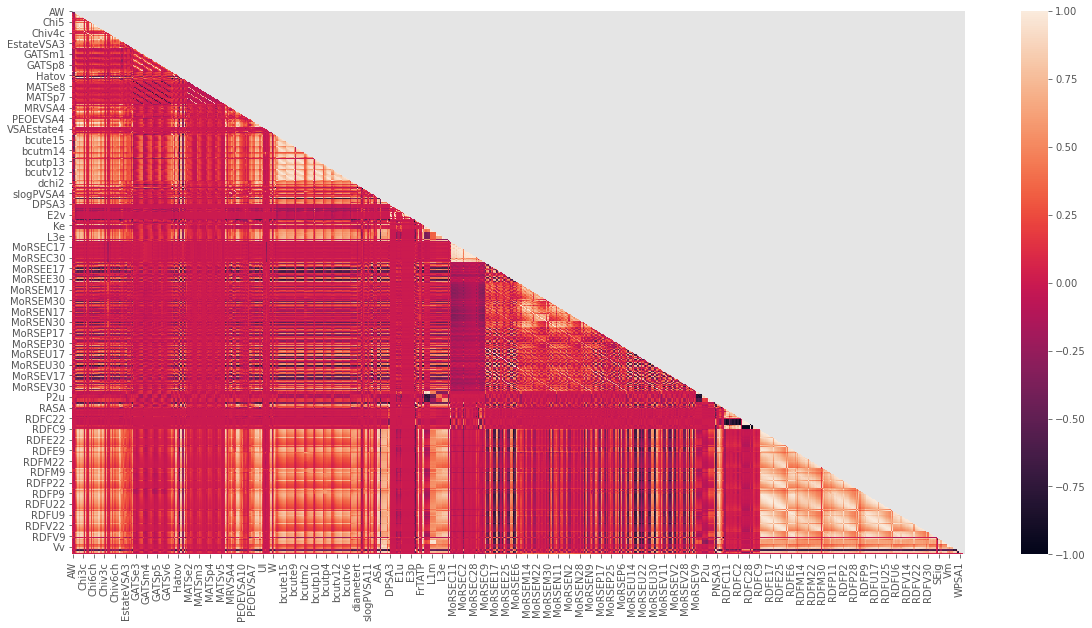

In [57]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask)

### Saving feature columns

In [48]:
df_feature.rename(columns={"Unnamed: 0":"id"},inplace=True)
df_feature.to_csv('../input/processed/train_features.csv',index=False)

In [49]:
df_feature_test.rename(columns={"Unnamed: 0":"id"},inplace=True)
df_feature_test.to_csv('../input/processed/test_features.csv',index=False)

## Testing codes

#### PCA

In [50]:
leftdf = pd.DataFrame({'A':np.random.rand(10),'B':np.random.randn(10)})
rightdf = pd.DataFrame({'A':np.random.rand(10),'B':np.random.randn(10)}).add_suffix('_pred')

In [51]:
pd.concat([leftdf,rightdf],axis=1,)

,A,B,A_pred,B_pred
0,0.954398,-2.292702,0.028027,0.790201
1,0.528364,-0.247594,0.051339,-0.706737
2,0.932507,0.707141,0.667302,-3.302085
3,0.106075,0.304222,0.776054,-0.235134
4,0.015082,-0.149122,0.736159,-0.527464
5,0.433940,-0.994638,0.981620,0.288992
6,0.901860,0.414555,0.493608,1.078482
7,0.083119,-1.328025,0.635641,-1.228159
8,0.061434,0.542113,0.076413,0.087659
9,0.931943,1.539124,0.539554,0.026857
